In [11]:
import os
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union


In [2]:
# research area
place_name = "London, UK"

In [3]:
# get data from OpenStreetMap(bike)
graphml_filename = "london_bike_network.graphml"

if os.path.exists(graphml_filename):
    print(f"Loading bike road network from local file: {graphml_filename}")
    graph = ox.load_graphml(graphml_filename)
else:
    print("Downloading bike road network from OpenStreetMap...")
    graph = ox.graph_from_place(place_name, network_type='bike')
    
    ox.save_graphml(graph, graphml_filename)
    print(f"Graph saved locally as: {graphml_filename}")

Graph saved locally as: london_bike_network.graphml


In [4]:
# preprocess: simplified(没用？)
#graph = ox.simplify_graph(graph)

In [5]:
# Select Start & End point
origin_point = (51.5246584, -0.1339789) # ucl
destination_point = (51.5155, -0.1410) # 摄政街

In [6]:
# Locate the nearest OSM node
origin = ox.distance.nearest_nodes(graph, X=origin_point[1], Y=origin_point[0])
destination = ox.distance.nearest_nodes(graph, X=destination_point[1], Y=destination_point[0])

In [7]:
# Calculation 15 minute ride Accessibility (等时线)
cycling_speed = 250  # 250m/min（= 15km/h）
max_time = 5
max_distance = cycling_speed * max_time  # 单位：m

In [8]:
# Computing reachability range (Ego Graph)
subgraph = nx.ego_graph(graph, origin, radius=max_distance, distance="length")

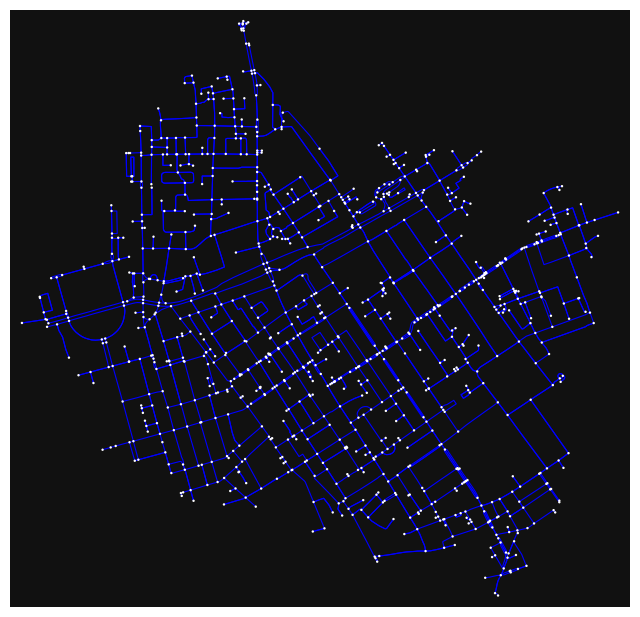

In [9]:
# vis
fig, ax = ox.plot_graph(subgraph, node_size=3, edge_color='blue', edge_linewidth=0.8)

In [14]:
edges_sub = ox.graph_to_gdfs(subgraph, nodes=False, edges=True)

# 注意坐标系投影
crs_utm = edges_sub.estimate_utm_crs()
edges_sub = edges_sub.to_crs(crs_utm)

# buffer（m）
buffer_size = 50
polygons = edges_sub.buffer(buffer_size)
# buffer几何合并
isochrone_area = unary_union(polygons)

# 去除碎片或做拓扑修正可加一次 buffer(0)
isochrone_area = isochrone_area.buffer(0)

# 构建GeoDataFrame
isochrone_gdf = gpd.GeoDataFrame(
    {'geometry': [isochrone_area]}, 
    crs=edges_sub.crs
)

out_dir = r"./a_shp"
os.makedirs(out_dir, exist_ok=True)

# 保存为 shapefile
out_file = os.path.join(out_dir, "isochrone_5min.shp")
isochrone_gdf.to_file(out_file, driver="ESRI Shapefile")

print("已保存为Shapefile:", out_file)

已保存为Shapefile: ./a_shp\isochrone_5min.shp
